In [4]:
import numpy as np
# import cupy as np  # run if you have an nvidia gpu

import pandas as pd
from matplotlib import pyplot as plt

In [5]:
# define our training parameters
WIDTH = 28
HEIGHT = 28
HIDDEN_LAYER_NEURONS = 150
OUTPUT_LAYER_NEURONS = 26
ITERATIONS = 5000

In [6]:
train_data = pd.read_csv('./data/emnist_fixed/uppercase_emnist_letters_train.csv')
test_data = pd.read_csv('./data/emnist_fixed/uppercase_emnist_letters_test.csv')

In [7]:
data_test = np.array(test_data).T
Y_test = data_test[0]
X_test = data_test[1:]
X_test = X_test / 255.

train_data = np.array(train_data)
np.random.shuffle(train_data)  # shuffle before splitting into dev and training sets
data_train = train_data.T
Y_train = data_train[0]
X_train = data_train[1:]
X_train = X_train / 255.
_, m_train = X_train.shape

In [8]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid_deriv(x):
    return sigmoid(x)*(1-sigmoid(x))

In [9]:
def init_params():
    """
    initialize the weights randomly between -0.5 and 0.5,
    if they are initialized with too high of a value we may cause the error to stagnate.
    """
    W1 = np.random.rand(HIDDEN_LAYER_NEURONS, WIDTH * HEIGHT) - 0.5
    b1 = np.random.rand(HIDDEN_LAYER_NEURONS, 1) - 0.5
    W2 = np.random.rand(OUTPUT_LAYER_NEURONS, HIDDEN_LAYER_NEURONS) - 0.5
    b2 = np.random.rand(OUTPUT_LAYER_NEURONS, 1) - 0.5
    return W1, b1, W2, b2


def forward_prop(W1, b1, W2, b2, X):
    """
    calculate the Zi and Ai for each layer respectively from the weights and biases
    """
    
    Z1 = W1@X + b1
    A1 = sigmoid(Z1)
    Z2 = W2@A1 + b2
    A2 = sigmoid(Z2)
    return Z1, A1, Z2, A2


def one_hot(Y: np.ndarray):
    """
    convert the correct Y to an array of indices (as shown in the slideshow)
    """
    
    one_hot_Y = np.zeros((Y.size, int(Y.max() + 1)))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y


def backward_prop(Z1, A1, A2, W2, X, Y):
    """
    calculate the respective derivatives of the variables, as shown in the slideshow
    """
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    
    n = Y.shape[0]  
    dW2 = 1 / n * dZ2@A1.T
    db2 = 1 / n * dZ2.sum()
    dZ1 = W2.T@dZ2 * sigmoid_deriv(Z1)
    dW1 = 1 / n * dZ1@X.T
    db1 = 1 / n * dZ1.sum()
    return dW1, db1, dW2, db2


def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    return W1, b1, W2, b2

In [10]:
def get_predictions(A2):
    return np.argmax(A2, 0)  # get the most "activated" neuron (the neuron with the greatest value)


def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size  # average of how many predictions were correct

In [11]:
# Save the neural network's weights and biases to a file
def dump_neurons(file_path, W1, b1, W2, b2):
    np.savez(file_path, W1=W1, b1=b1, W2=W2, b2=b2)
    print(f"Weights and biases saved to {file_path}")

# Load the neural network's weights and biases from a file
def load_neurons(file_path):
    data = np.load(file_path)
    print(f"Weights and biases loaded from {file_path}")
    if hasattr(data, "npz_file"):  # running in cupy
        return (data[key] for key in data.npz_file)
    
    return data.values()  # works only in numpy

In [12]:
def gradient_descent(X, Y, alpha, iterations, save="", load_from_save=""):
    W1, b1, W2, b2 = init_params()
    if load_from_save:  # load neurons from file to continue training
        W1, b1, W2, b2 = load_neurons(load_from_save)

    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, A2, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        
        if i % 200 == 0:  # print every 200 iterations
            print("Iteration: ", i, "Confidence:", get_accuracy(get_predictions(A2), Y))

    if save:
        dump_neurons(save, W1, b1, W2, b2)

    predictions = get_predictions(A2)
    print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2

In [13]:
# W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.10, ITERATIONS, "dump/train_neurons_w_b_5000_iter_150.npz")

Iteration:  0, &nbsp;  Confidence: 0.027596596099296464 \
Iteration:  200, &nbsp;  Confidence: 0.5022836904437571 \
Iteration:  400, &nbsp;  Confidence: 0.6164521867337618 \
Iteration:  600, &nbsp;  Confidence: 0.6617894517540345 \
Iteration:  800, &nbsp;  Confidence: 0.6882001314123624 \
Iteration:  1000, &nbsp;  Confidence: 0.7077036490969406 \
Iteration:  1200, &nbsp;  Confidence: 0.721710283818651 \
Iteration:  1400, &nbsp;  Confidence: 0.7333611115562749 \
Iteration:  1600, &nbsp;  Confidence: 0.7428163912883219 \
Iteration:  1800, &nbsp;  Confidence: 0.7507812625202327 \
Iteration:  2000, &nbsp;  Confidence: 0.7577845798810878 \
Iteration:  2200, &nbsp;  Confidence: 0.7640507059408004 \
Iteration:  2400, &nbsp;  Confidence: 0.7701405471241526 \
Iteration:  2600, &nbsp;  Confidence: 0.7754931970063623 \
Iteration:  2800, &nbsp;  Confidence: 0.7804451994422987 \
Iteration:  3000, &nbsp;  Confidence: 0.7848683472491547 \
Iteration:  3200, &nbsp;  Confidence: 0.7888427699161845 \
Iteration:  3400, &nbsp;  Confidence: 0.7926889854004071 \
Iteration:  3600, &nbsp;  Confidence: 0.7961826311319091 \
Iteration:  3800, &nbsp;  Confidence: 0.7994839660892001 \
Iteration:  4000, &nbsp;  Confidence: 0.8027853010464912 \
Iteration:  4200, &nbsp;  Confidence: 0.8059103511274219 \
Iteration:  4400, &nbsp;  Confidence: 0.8090514271062036 \
Iteration:  4600, &nbsp;  Confidence: 0.8118078815365631 \
Iteration:  4800, &nbsp;  Confidence: 0.8141476626227985 \
Weights and biases saved to dump/train_neurons_w_b_5000_iter_150.npz \
0.8167438580746487

Lets test the runtime speed for 1000 iterations:\
\
$\begin{array}{|c|c|c|}
\hline
\text{Number of Neurons} & \text{Error} & \text{Runtime} \\
\hline
26  & 0.6000  & 13.2\text{s} \\
52  & 0.6472  & 24.8\text{s} \\
100 & 0.6875  & 1\text{m}1.8\text{s} \\
150 & 0.7106 & 1\text{m}20\text{s} \\
200 & 0.7225  & 1\text{m}34.5\text{s} \\
485 & 0.7571  & 3\text{m}34.9\text{s} \\
\hline
\end{array}$
\
\
total training time for 5000 iterations with 150 neurons in the hidden layer was 8m25.4s

In [14]:
W1, b1, W2, b2 = load_neurons("dump/train_neurons_w_b_5000_iter_150.npz")

Weights and biases loaded from dump/train_neurons_w_b_5000_iter_150.npz


In [15]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions


def test_prediction(X, Y, index, W1, b1, W2, b2):
    current_image = X[:, index, None]
    prediction = make_predictions(X[:, index, None], W1, b1, W2, b2)
    label = Y[index]
    print("Prediction:", chr((prediction[0] + 65).item()))
    print("Label:", chr((label + 65).item()))

    current_image = current_image.reshape((WIDTH, HEIGHT)) * 255
    plt.gray()
    if hasattr(np, "asnumpy"):  # running in cupy
        plt.imshow(np.fliplr(np.rot90(np.asnumpy(current_image),axes=(1,0))) , interpolation='nearest')
    else:  # running in numpy
        plt.imshow(np.fliplr(np.rot90(current_image,axes=(1,0))) , interpolation='nearest')
    plt.show()


Let's look at a couple of examples:

Prediction: E
Label: E


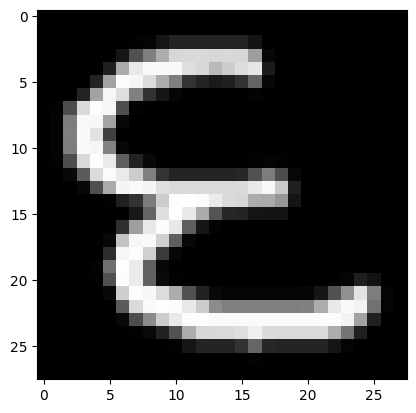

Prediction: C
Label: C


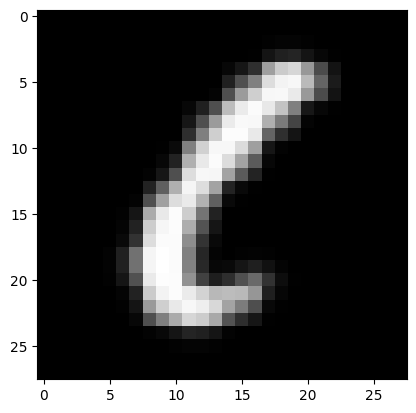

Prediction: Z
Label: Z


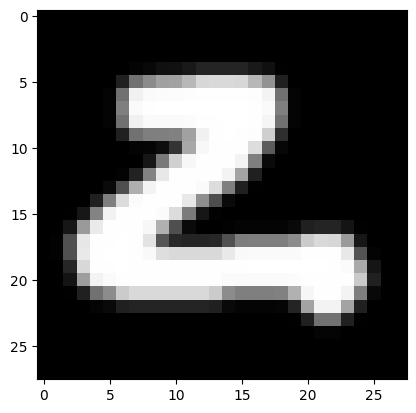

Prediction: X
Label: X


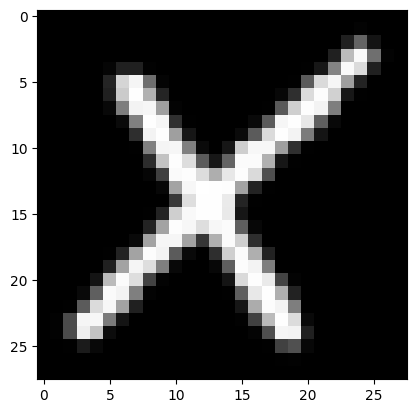

In [16]:

test_prediction(X_test, Y_test, 1, W1, b1, W2, b2)
test_prediction(X_test, Y_test, 3, W1, b1, W2, b2)
test_prediction(X_test, Y_test, 10, W1, b1, W2, b2)
test_prediction(X_test, Y_test, 11, W1, b1, W2, b2)

But the nn doesnt get everything right all the time, shapes that are similar may confuse it, for example this G that's close to an O

Prediction: O
Label: G


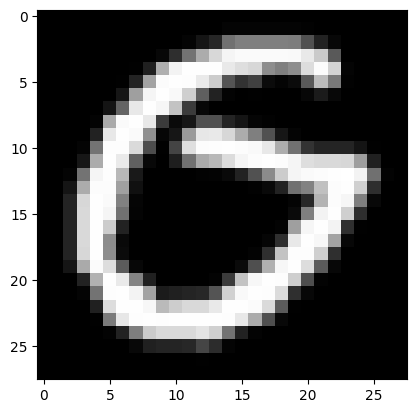

In [17]:
test_prediction(X_test, Y_test, 6, W1, b1, W2, b2)

Finally, let's find the accuracy on the testing set:

In [18]:
train_predictions = make_predictions(X_train, W1, b1, W2, b2)
print(f"final training dataset prediction accuracy: {np.round(get_accuracy(train_predictions, Y_train) * 100, 2)}%")
test_predictions = make_predictions(X_test, W1, b1, W2, b2)
print(f"final testing dataset prediction accuracy: {np.round(get_accuracy(test_predictions, Y_test) * 100, 2)}%")

final training dataset prediction accuracy: 81.67%
final testing dataset prediction accuracy: 80.07%


In [19]:
hand_drawn_data = pd.read_csv('./hand_drawn/output.csv')
hand_drawn_data = np.array(hand_drawn_data).T
Y_hand_drawn = hand_drawn_data[0]
X_hand_drawn = hand_drawn_data[1:]
X_hand_drawn = X_hand_drawn / 255.

Prediction: Q
Label: Q


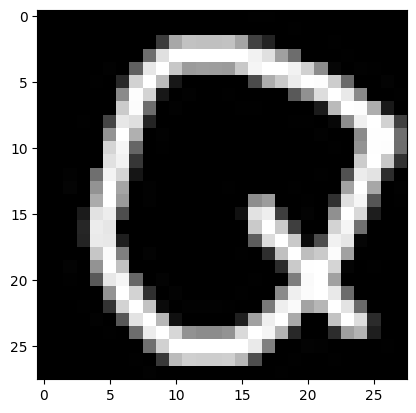

In [20]:
test_prediction(X_hand_drawn, Y_hand_drawn, 1, W1, b1, W2, b2)

Prediction: W
Label: 0


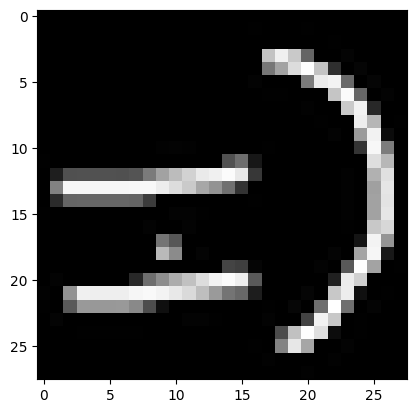

Prediction: Q
Label: Q


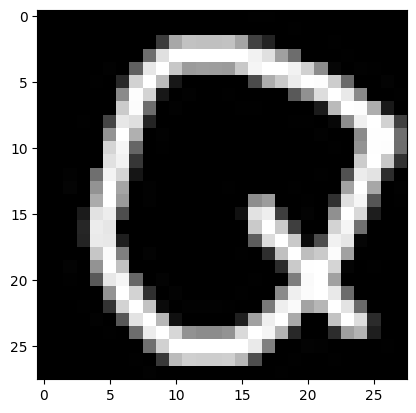

In [25]:
test_prediction(X_hand_drawn, Y_hand_drawn, 0, W1, b1, W2, b2)
test_prediction(X_hand_drawn, Y_hand_drawn, 1, W1, b1, W2, b2)

credit to [wwsalmon's code on kagggle](https://www.kaggle.com/code/wwsalmon/simple-mnist-nn-from-scratch-numpy-no-tf-keras), who'se version we have used as basis for our neural network \
and the [Extended MNIST](https://www.kaggle.com/datasets/crawford/emnist) dataset